# Deep Convolutional Generative Adversarial Networks

# Objective

The objective of this work is to continue learning about the functioning of neural networks, in this case, exploring the GAN architecture to generate new instances of a dataset for another work. Tthe FashionMNIST dataset will be used to train a DCGAN network and generate new instances.

# Set Up

## Install libraries and imports

In [1]:
!pip install imageio
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 744.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.7 MB/s eta 0:00:00


In [2]:
import argparse
import glob
import math
import os
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
import torchvision
import time
from IPython import display
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
import random
from IPython.display import Image, display, clear_output
tf.__version__

'2.15.0'

## Download dataset FashionMNIST

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
indices = list(range(len(full_dataset)))
np.random.shuffle(indices)

train_subset = Subset(full_dataset, indices)
train_dataset = []

for index in range(len(train_subset)):
    image, label = train_subset[index]
    train_dataset.append(image.numpy())

train_dataset = np.array(train_dataset)
print("Train dataset shape:", train_dataset.shape)


100%|██████████| 26421880/26421880 [00:02<00:00, 11891405.75it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212561.72it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3752640.61it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10806945.44it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train dataset shape: (60000, 1, 28, 28)


Print some images from the dataset.

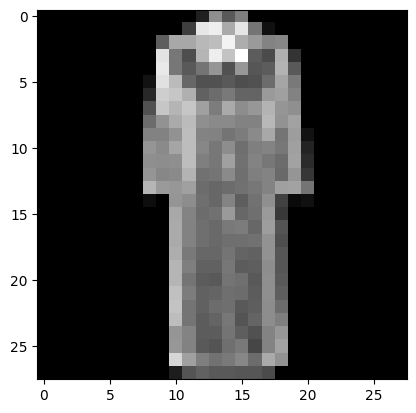

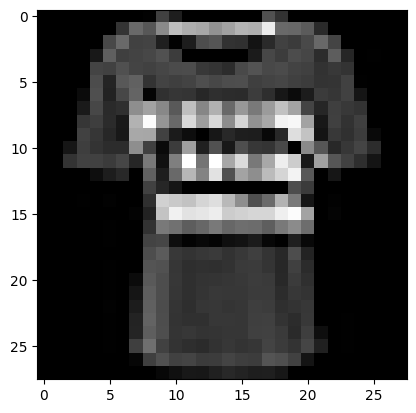

In [4]:
random_indices = random.sample(range(len(train_dataset)), 2)
for index in random_indices:
    image = train_dataset[index]
    plt.figure()
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()

# PyTorch

### Source: https://github.com/eriklindernoren/PyTorch-GAN

## Define training parameters such as image size, batch size, epochs

In [31]:
DEBUG = True
class OPT:
    def __init__(self):
        self.n_epochs = 50
        self.batch_size = 32
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 28
        self.channels = 1
        self.sample_interval = 400
opt = OPT()
img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False
print("cuda: ",cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda:  True


## Define the model

In [11]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        print("init_size", self.init_size)
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

## This function allows us to print images at any epoch and save it as a file

In [21]:
z_rand = torch.randn(5, 100)

def show_images(generator, epoch=0):
    device = next(generator.parameters()).device

    images = generator(z_rand.to(device))

    if device.type == 'cuda':
        images = images.cpu()

    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for idx, img in enumerate(images):
        img = img.detach().numpy().squeeze()
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


## Define the train method

In [23]:
def train_model(opt,generator,discriminator):
  adversarial_loss = torch.nn.BCELoss()
  if cuda:
    adversarial_loss.cuda()
  optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
  optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

  Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

  # ----------
  #  Training
  # ----------

  # Crear el conjunto de datos personalizado

  dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ]), download=True),
    batch_size=opt.batch_size,
    shuffle=True,
  )
  # Utilizar el conjunto de datos con un DataLoader
  for epoch in range(opt.n_epochs):
    show_images(generator,epoch)
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        clear_output(wait=True)
        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch+1, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )


## Train the model

In [32]:
generator = Generator()
discriminator = Discriminator()
if cuda:
    generator.cuda()
    discriminator.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)
train_model(opt,generator,discriminator)

[Epoch 50/50] [Batch 1874/1875] [D loss: 0.565469] [G loss: 0.679887]


In [ ]:
show_images(generator,opt.num_epochs)

# Evolution of instance generator amongst the training epochs

You can run the cell below and see the model evolution as a GIF. Change the directory to '50_epochs' to see a 50-epoch generator evolotion

Epoch:  49


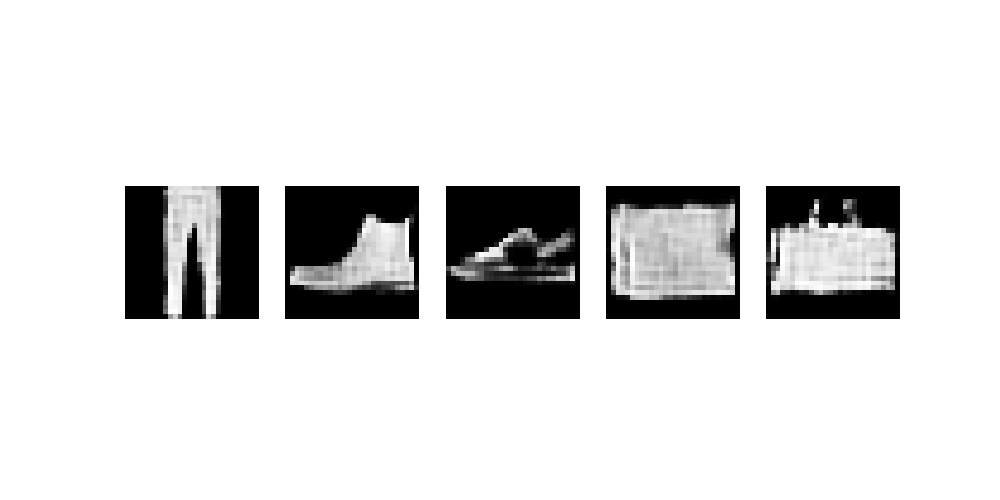

In [32]:
# Set velocity here
sleep_time = 0.5
directory = '50_epochs'
images = []

for filename in sorted(os.listdir(directory)):
    if filename.endswith(".png"):
        images.append(filename)

images.sort(key=lambda x: int(x.split('_')[3].split('.')[0]))

gif_images = []
for filename in images:
    with open(os.path.join(directory, filename), 'rb') as f:
        gif_images.append(f.read())
i = 0
for image_data in gif_images:
    clear_output(wait=True)
    print("Epoch: ",i)
    i+=1
    display(Image(data=image_data, format='png'))
    time.sleep(sleep_time)